<center><font size = "10"> Week 9 - STDP<center>
<center><font size = "8">Tutorial 01: spike-timing dependent plasticity<center>

<font color='blue'><font size=3>In this tutorial you will:
    
<font color='blue'><font size=3>- build a model of synapse that shows spike-timing dependent plasticity (STDP)
    
<font color='blue'><font size=3>- study how correlations in input spike trains influence the distribution of conductances and synaptic weights


<font size="5">
Towards these goals, we will model the presynaptic input as Poisson type spike trains. To make things easier we will *not* be using NEURON simulator this time, but instead we implement a leaky integrate-and-fire neuron in python. LIF models are a simplified way to represent neurons in which we do not model their cable properties, ion channels, or kinetics, but simply model their membrane potential as a single value. 

Throughout this tutorial, we assume that a single postsynaptic neuron is driven by 𝑁
presynaptic neurons. That is, there are 𝑁 synapses, and we will study how their weights depend on the statistics or the input spike trains and their timing with respect to the spikes of the postsynaptic neuron.

The phenomenology of STDP is generally described as a biphasic exponentially decaying function. That is, the instantaneous change in weights is given by:

$$
\Delta W = A_+ e^{(t_{\text{pre}} - t_{\text{post}})/\tau_+} \quad\quad \text{if } t_{\text{post}} > t_{\text{pre}}
$$

$$
\Delta W = -A_- e^{-(t_{\text{pre}} - t_{\text{post}})/\tau_-} \quad\quad \text{if } t_{\text{post}} < t_{\text{pre}}
$$


where:
- Δ𝑊 is the change in the synaptic weight
- 𝐴+ and 𝐴− determine the maximum amount of synaptic modification (which occurs when the timing difference between presynaptic and postsynaptic spikes is close to zero)
- 𝜏+ and 𝜏− determine the ranges of pre-to-postsynaptic interspike intervals over which synaptic strengthening or weakening occurs. Thus, Δ𝑊>0 means that postsynaptic neuron spikes after the presynaptic neuron.

This model captures the phenomena that repeated occurrences of presynaptic spikes within a few milliseconds before postsynaptic action potentials lead to long-term potentiation (LTP) of the synapse, whereas repeated occurrences of presynaptic spikes after the postsynaptic ones lead to long-term depression (LTD) of the same synapse.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import time

## 1. Changes in ∆W during STDP

In [2]:
# First let's create some functions to help us with this purpose

# Define parameters of the STDP process
def default_pars_STDP(**kwargs):
    pars = {}
    
    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)
    
    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]
    
    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]
    
    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]
    return pars

# Create a function for a funny plot
def mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW):
    plt.figure(figsize=(10, 5))
    plt.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')
    
    plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
    plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')
    
    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W', fontsize=12)
    plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
    plt.show()

# Fuction to compute the exponentials
def Delta_W(pars, A_plus, A_minus, tau_stdp):
    """
    Plot STDP biphasic exponential decaying function
    Args:
        pars       : parameter dictionary
        A_plus     : (float) maximum amount of synaptic modification
                     which occurs when the timing difference between pre- and
                     post-synaptic spikes is positive
        A_minus    : (float) maximum amount of synaptic modification
                     which occurs when the timing difference between pre- and
                     post-synaptic spikes is negative
        tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                     over which synaptic strengthening or weakening occurs
      Returns:
        dW         : instantaneous change in weights
    """
    
    # STDP change
    dW = np.zeros(len(time_diff))
    # Calculate dW for LTP
    dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
    # Calculate dW for LTD
    dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)
    return dW

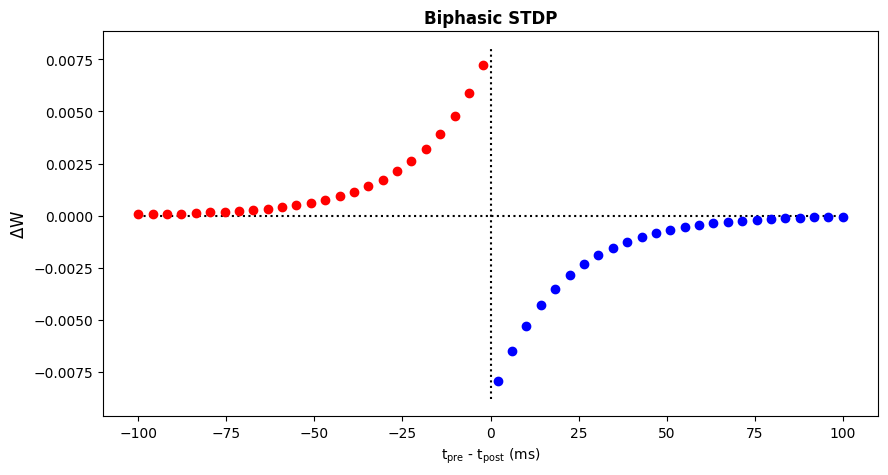

In [3]:
# Run the previous functions
pars = default_pars_STDP()

# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']

# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp);


mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW);

## 2. Keep track of pre- and post- synaptic spikes during simulation

To do so, we will use the following expressions:
$$
post-cell: 𝜏_−\frac{𝑑𝑀}{𝑑𝑡} = −𝑀 \quad , \quad \text{when the postsynaptic neuron spikes then:}\quad 𝑀(𝑡) = 𝑀(𝑡) − 𝐴_− \quad , \quad \text{M(t) tracks the number of post-spikes}
$$
$$
pre-cell: 𝜏_+\frac{𝑑P}{𝑑𝑡} = −P \quad , \quad \text{when the presynaptic neuron spikes then:}\quad P(𝑡) = P(𝑡) + 𝐴_+ \quad , \quad \text{P(t) tracks the number of pre-spikes}
$$

Now imagine that we have one postsynaptic neuron which receives Poisson type spiking inputs from five presynaptic neurons.

We can simulate 𝑃 for each one of the presynaptic neurons.


In [4]:
def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains
    Args:
        pars            : parameter dictionary
        rate            : noise amplitute [Hz]
        n               : number of Poisson trains
        myseed          : random seed. int or boolean
    Returns:
        pre_spike_train : spike train matrix, ith row represents whether
                          there is a spike in ith spike train over time
                          (1 if spike, 0 otherwise)
    """
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : binary spike train input from
                             presynaptic excitatory neuron
    Returns:
        P                  : LTP ratio
    """
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # Calculate the delta increment dP
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP
    return P

def my_example_P(pre_spike_train_ex, pars, P):
    """Generates two plots (raster plot and LTP vs time plot)
    Args:
        pre_spike_train_ex     : spike-train
        pars : dictionary with the parameters
        P : LTP ratio
    Returns:
        my_example_P returns a rastert plot (top),
        and a LTP ratio across time (bottom)
    """
    spT = pre_spike_train_ex
    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    color_set = ['red', 'green', 'black', 'blue', 'orange']
    for i in range(spT.shape[0]):
        t_sp = pars['range_t'][spT[i, :] > 0.5]   # spike times
        plt.plot(t_sp, i*np.ones(len(t_sp)), '|',
                 color=color_set[i],
                 ms=10, markeredgewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.xlim(50, 200)

    plt.subplot(212)
    for k in range(5):
        plt.plot(pars['range_t'], P[k, :], color=color_set[k], lw=1.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('P(t)')
    plt.xlim(50, 200)

    plt.tight_layout()
    plt.show()


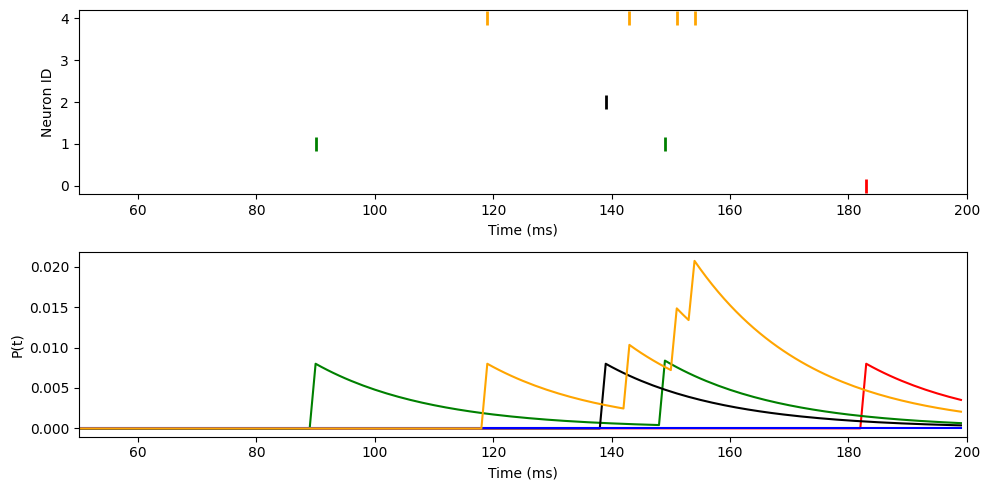

In [5]:
pars = default_pars_STDP(T=200., dt=1.)
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=2020)
P = generate_P(pars, pre_spike_train_ex)

my_example_P(pre_spike_train_ex, pars, P)

## 3. Implementing STDP

<font size="5">

To implement STDP in spiking networks, we will change the value of the peak synaptic conductance based on the presynaptic and postsynaptic timing, thus using the variables 𝑃(𝑡) and 𝑀(𝑡).

Each synapse (i) has its own peak synaptic conductance ($g_i$), which may vary between [0, gmax] and will be modified depending on the presynaptic and postsynaptic timing.

When the 𝑖𝑡ℎ presynaptic neuron elicits a spike, its corresponding peak conductance is updated according to the following equation:
$$
g_{i} = g_i + M(t)g_{max}
$$

Note that, 𝑀(𝑡) tracks the time since the last postsynaptic potential and is always negative. Hence, if the postsynaptic neuron spikes shortly before the presynaptic neuron, the above equation shows that the peak conductance will decrease.

When the postsynaptic neuron spikes, the peak conductance of each synapse is updated according to:
$$
g_{i} = g_i + P_i(t)g_{max}
$$

Note that, $P_i(t)$ tracks the time since the last spike of ith pre-synaptic neuron and is always positive.

Thus, the equation given above shows that if the presynaptic neuron spikes before the postsynaptic neuron, its peak conductance will increase.

#### Prepare the simulation 

Let's connect 300 presynaptic neurons to a single postsynaptic neuron. We do not need to simulate the dynamics of each presynaptic neuron as we are only concerned about their spike times. So, we will generate 5 Poisson type spikes. Here, we will assume that all these inputs are excitatory.

We need to simulate the dynamics of the postsynaptic neuron as we do not know its spike times. We model the postsynaptic neuron as an LIF neuron receiving only excitatory inputs.

$$
\tau_m\frac{dV}{dt} = -(V(t) - E_L) - g_E(t)(V(t) - E_E)
$$
where $E_L$ and $E_E$ are the leak reversal potential and the excitatory reversal potential, and the total excitatory synaptic conductance $g_E(t)$ is given by:
$$
g_E(t) = \sum_{i=1}^N g_i(t)
$$

While simulating STDP, it is important to make sure that $g_i$ never goes outside of its bounds.

In [6]:
# Function for LIF neuron with STDP synapses

def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    """
    conductance-based LIF dynamics

    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : spike train input from presynaptic excitatory neuron

    Returns:
        rec_spikes         : spike times
        rec_v              : mebrane potential
        gE                 : postsynaptic excitatory conductance
    """

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = generate_P(pars, pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:   # reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref / dt

        # update the synaptic conductance
        M[it + 1] = M[it] - dt / tau_stdp * M[it]
        gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it + 1] < 0
        gE_bar_update[id_temp, it + 1] = 0.

        # calculate the increment of the membrane potential
        dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

        # update membrane potential
        v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

### Let's define the plotting functions

In [7]:
# Figures of the evolution of synaptic conductance
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains

    Args:
        range_t     : time sequence
        spike_train : binary spike trains, with shape (N, Lt)
        n           : number of Poisson trains plot

    Returns:
        Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
        print('The number n exceeds the size of spike trains')
        print('The number n is set to be the size of spike trains')
        n = N

    # Raster plot
    i = 0
    while i <= n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

def make_plot():    
    # Run this cell to see the figures!
    plt.figure(figsize=(12, 5))
    plt.subplot(221)
    dt, range_t = pars['dt'], pars['range_t']
    if rec_spikes.size:
        sp_num = (rec_spikes / dt).astype(int) - 1
        v[sp_num] += 10   # add artificial spikes
    plt.plot(pars['range_t'], v, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')

    plt.subplot(222)
    # Plot the sample presynaptic spike trains
    my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)

    plt.subplot(223)
    plt.plot(pars['range_t'], M, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('M')

    plt.subplot(224)
    for i in range(10):
        plt.plot(pars['range_t'], P[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('P')

    plt.tight_layout()
    plt.show()

### Let's run a simulation and plot the results

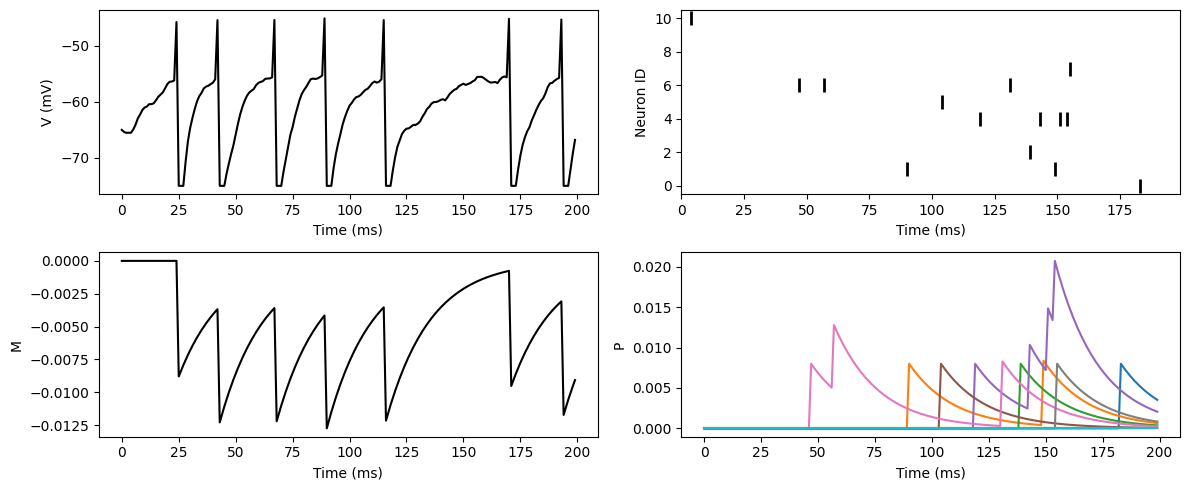

In [8]:
pars = default_pars_STDP(T=200., dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024                   # max synaptic conductance
pars['gE_init'] = 0.024                  # initial synaptic conductance
pars['VE'] = 0.                          # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)

# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,pre_spike_train_ex)
make_plot()

## Let's see the evolution of synaptic weights

<font size="5">

We would like to know how the distribution of synaptic weights evolves as a function of time.

To get a better estimate of the weight distribution and its time evolution, we will increase the presynaptic firing rate to 15
Hz and simulate the postsynaptic neuron for 120s.

In [10]:
# Figure Settings
import ipywidgets as widgets       # interactive display
my_layout = widgets.Layout()

# Functions for simulating a LIF neuron with STDP synapses
def example_LIF_STDP(inputrate=15, Tsim=120000, pop_size=300, tau_e=5):
    """ Simulation of a LIF model with STDP synapses
    Args:
        intputrate  :  The rate used for generate presynaptic spike trains
        Tsim        :  Total simulation time
    output:
        Interactive demo, Visualization of synaptic weights
    """
    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar'] = 0.024
    pars['gE_init'] = 0.014     # initial synaptic conductance
    pars['VE'] = 0.             # [mV]
    pars['tau_syn_E'] = tau_e   # [ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=inputrate, n=pop_size, myseed=2020)  # generate Poisson trains
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)  # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar']  # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime) / 60.
    
    my_layout.width = '620px'
    @widgets.interact(sample_time=widgets.FloatSlider(0.5, min=0., max=1., step=0.1,layout=my_layout))

    def my_visual_STDP_distribution(sample_time=0.0):
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time * (sample_time > 0)

        plt.figure(figsize=(8, 8))
        ax1 = plt.subplot(211)
        for i in range(50):
            ax1.plot(pars['range_t'][::1000] / 1000., gE_bar_update[i, ::1000], lw=1., alpha=0.7)

        ax1.axvline(1e-3 * pars['range_t'][sample_time], 0., 1., color='k', ls='--')
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')

        bins = np.arange(-.05, 1.05, .05)
        g_dis, _ = np.histogram(gbar_norm[:, sample_time], bins)
        ax2 = plt.subplot(212)
        ax2.bar(bins[1:], g_dis, color='g', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s' % (1e-3 * pars['range_t'][sample_time])),fontweight='bold')
        plt.tight_layout()
        plt.show()

In [ ]:
example_LIF_STDP(inputrate=15,Tsim=120000)